### VaMoS'23

Two goals:
- launching some graphs about the coreutils data
- computing correlations between #locs, #runtime options and binary size of small programs extracted out of coreutils, see https://github.com/coreutils/coreutils

### Libs

In [49]:
import os 

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib.ticker import ScalarFormatter

from scipy.stats import spearmanr

### Importing data runtime

In [2]:
df = pd.read_csv("../measures/table1.csv")
df = df.dropna().reset_index()
df

,index,name,loc,binary,runtime
0,2,basename,133.0,165.0,3
1,3,cat,526.0,186.0,7
2,4,chcon,447.0,310.0,9
3,5,chgrp,250.0,301.0,7
4,6,chmod,436.0,286.0,7
...,...,...,...,...,...
88,92,users,104.0,169.0,0
89,94,wc,808.0,252.0,6
90,95,who,621.0,198.0,14
91,96,whoami,59.0,163.0,0


### Get usage of the different functions in the linux kernel

#### List all bash files in the Linux kernel

In [3]:
linux_dir = '../../linux-master/'
# after cloning https://github.com/torvalds/linux 

all_files = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(linux_dir)) for f in fn]

all_bash_files = [f for f in all_files if f[-3:]=='.sh']

# number of bash files
len(all_bash_files)

745

#### List all words in the bash files

In [4]:
words = []

for bash_f in all_bash_files:
    file = open(bash_f, 'r')
    read_data = file.read()
    per_word = read_data.split()
    words.extend(per_word)

len(words)

500836

In [5]:
all_bash_files

['../../linux-master/Documentation/sound/cards/multisound.sh',
 '../../linux-master/Documentation/admin-guide/aoe/status.sh',
 '../../linux-master/Documentation/admin-guide/aoe/udev-install.sh',
 '../../linux-master/Documentation/admin-guide/aoe/autoload.sh',
 '../../linux-master/Documentation/features/list-arch.sh',
 '../../linux-master/Documentation/features/scripts/features-refresh.sh',
 '../../linux-master/Documentation/s390/config3270.sh',
 '../../linux-master/Documentation/arm64/kasan-offsets.sh',
 '../../linux-master/Documentation/sphinx/parallel-wrapper.sh',
 '../../linux-master/arch/x86/boot/genimage.sh',
 '../../linux-master/arch/x86/boot/install.sh',
 '../../linux-master/arch/x86/kernel/cpu/mkcapflags.sh',
 '../../linux-master/arch/x86/entry/vdso/checkundef.sh',
 '../../linux-master/arch/x86/um/vdso/checkundef.sh',
 '../../linux-master/arch/riscv/boot/install.sh',
 '../../linux-master/arch/riscv/kernel/compat_vdso/gen_compat_vdso_offsets.sh',
 '../../linux-master/arch/riscv/

#### Initiate a dictionary with the count of coreutils functions

In [6]:
name = df['name']

countw = dict()

for n in name:
    countw[n] = 0

for w in words:
    for n in name:
        if n in w:
            countw[n]+=1

countw

{'basename': 82,
 'cat': 1078,
 'chcon': 0,
 'chgrp': 0,
 'chmod': 11,
 'chown': 7,
 'chroot': 0,
 'cksum': 60,
 'comm': 612,
 'cp': 1609,
 'csplit': 0,
 'cut': 269,
 'date': 334,
 'dd': 10163,
 'df': 42,
 'dircolors': 0,
 'dirname': 171,
 'du': 2189,
 'echo': 5920,
 'env': 62,
 'expand': 21,
 'expr': 68,
 'factor': 5,
 'false': 143,
 'fmt': 5,
 'fold': 5,
 'groups': 72,
 'head': 403,
 'hostid': 3,
 'hostname': 4,
 'id': 6896,
 'install': 468,
 'join': 191,
 'kill': 217,
 'link': 5578,
 'ln': 133,
 'logname': 0,
 'ls': 2577,
 'mkdir': 90,
 'mkfifo': 0,
 'mknod': 11,
 'mktemp': 254,
 'mv': 62,
 'nice': 6,
 'nl': 1623,
 'nohup': 3,
 'nproc': 9,
 'numfmt': 0,
 'od': 3399,
 'paste': 1,
 'pathchk': 0,
 'pinky': 0,
 'pr': 7405,
 'printenv': 0,
 'printf': 805,
 'ptx': 1,
 'pwd': 25,
 'readlink': 14,
 'realpath': 24,
 'rm': 1596,
 'rmdir': 25,
 'runcon': 0,
 'seq': 265,
 'shred': 0,
 'shuf': 8,
 'sleep': 872,
 'sort': 110,
 'split': 57,
 'stat': 1754,
 'stdbuf': 41,
 'stty': 1,
 'sum': 396,
 '

#### Join the data to the current dataframe

In [7]:
cn = [countw[n] for n in name]

usage = []
# 2 = high usage, ofetn used
# 1 = medium, not so often but still
# 0 = few utilisations of the coreutils function

for i in range(len(cn)):
    if cn[i] > 1000:
        usage.append(2)
    else:
        if cn[i] > 50:
            usage.append(1)
        else:
            usage.append(0)

df['usage'] = usage
df

,index,name,loc,binary,runtime,usage
0,2,basename,133.0,165.0,3,1
1,3,cat,526.0,186.0,7,2
2,4,chcon,447.0,310.0,9,0
3,5,chgrp,250.0,301.0,7,0
4,6,chmod,436.0,286.0,7,0
...,...,...,...,...,...,...
88,92,users,104.0,169.0,0,1
89,94,wc,808.0,252.0,6,1
90,95,who,621.0,198.0,14,0
91,96,whoami,59.0,163.0,0,0


## Bubble Chart

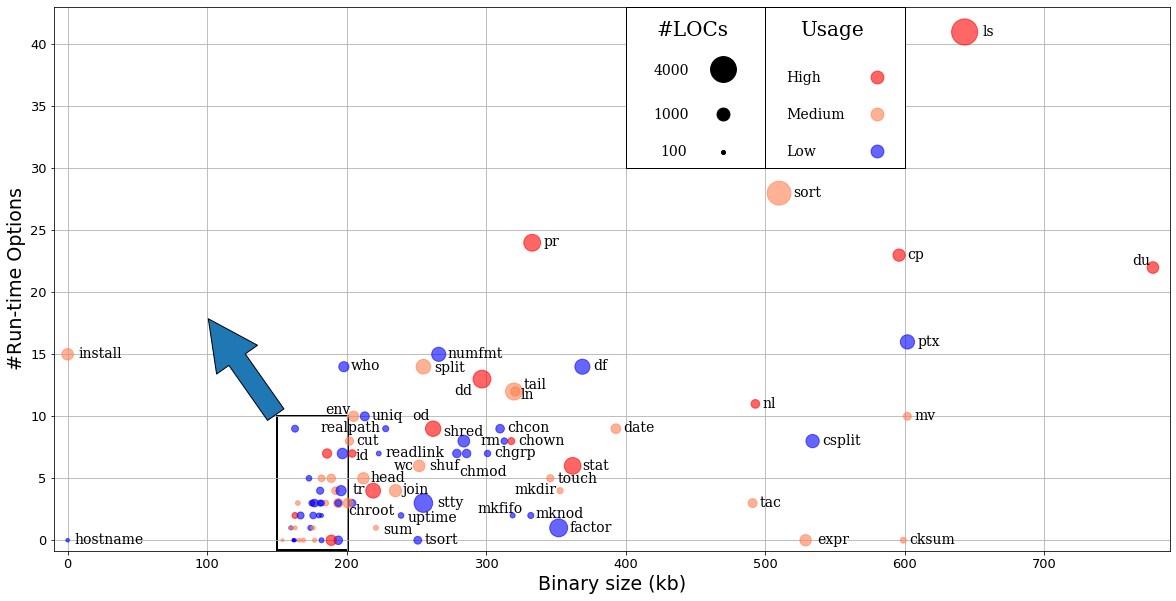

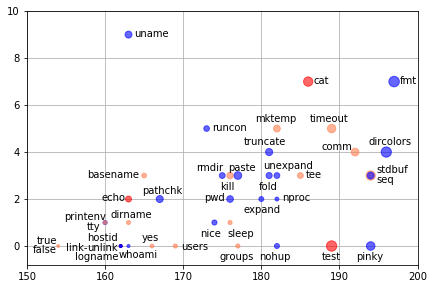

In [19]:
fig, ax = plt.subplots(1,figsize=(20,10))

loc = np.array(df['loc']/6, int)
binn = df['binary']
runt = np.array(df['runtime'], dtype=float)
name = df['name']
usage = df['usage']

alpha = 0.6
color = ['blue', 'coral', 'red']

plt.scatter(binn, runt, s=loc, alpha= alpha, color= [color[us] for us in usage], zorder=3)

positions = dict({
'basename' : (-8, 0),
'cat' : (0, 0),
'chcon' : (0, 0),
'chgrp' : (0, 0),
'chmod' : (-10, -1.5),
'chown' : (5, 0),
'chroot' : (-8, -0.7),
'cksum' : (-1, 0),
'comm' : (-5, 0.2),
'cp' : (1, 0),
'csplit' : (2, 0),
'cut' : (0, 0),
'date' : (0, 0),
'dd' : (-25, -1),
'df' : (3, 0),
'dircolors' : (-3, 0.4),
'dirname' : (-3, 0.3),
'du' : (-20, 0.5),
'echo' : (-4.2, 0),
'env' : (-25, 0.5),
'expand' : (-3, -0.5),
'expr' : (3, 0),
'factor' : (3, 0),
'false' : (-4, -0.2),
'fmt' : (0, 0),
'fold' : (-2, -0.5),
'groups' : (-3, -0.5),
'head' : (0, 0),
'hostid' : (-5, 0.3),
'hostname' : (0, 0),
'id' : (-3, -0.2),
'install' : (3, 0),
'join' : (0, 0),
'kill' : (-2, -0.5),
'link' : (-7.7, -0.1),
'ln' : (-1, -0.3),
'logname' : (-6.5, -0.5),
'ls' : (8, 0),
'mkdir' : (-38, 0),
'mkfifo' : (-30, 0.5),
'mknod' : (-2, 0.1),
'mktemp' : (-3.5, 0.4),
'mv' : (0, 0),
'nice' : (-2.5, -0.5),
'nl' : (0, 0),
'nohup' : (-3, -0.5),
'nproc' : (0, 0),
'numfmt' : (1, 0),
'od' : (-20, 1),
'paste' : (-2, 0.3),
'pathchk' : (-3, 0.3),
'pinky' : (-2.5, -0.5),
'pr' : (3, 0),
'printenv' : (-6, 0.2),
'printf' : (0, 0),
'ptx' : (2, 0),
'pwd' : (-4, 0),
'readlink' : (0, 0),
'realpath' : (-52, 0),
'rm' : (-27, 0),
'rmdir' : (-4, 0.3),
'runcon' : (0, 0),
'seq' : (0, -0.2),
'shred' : (-20, 0.7),
'shuf' : (-25, -1),
'sleep' : (-1, -0.5),
'sort' : (5, 0),
'split' : (3, -0.1),
'stat' : (2, 0),
'stdbuf' : (0, 0.2),
'stty' : (5, 0),
'sum' : (0, -0.2),
'tac' : (0, 0),
'tail' : (2, 0.5),
'tee' : (0, 0),
'test' : (-2, -0.5),
'timeout' : (-3.5, 0.4),
'touch' : (0, -0.1),
'tr' : (-20, 0),
'true' : (-3.5, 0.2),
'truncate' : (-4, 0.4),
'tsort' : (0, 0),
'tty' : (-3, -0.2),
'uname' : (0, 0),
'unexpand' : (-2.5, 0.4),
'uniq' : (0, 0),
'unlink' : (-5, -0.1),
'uptime' : (0, -0.2),
'users' : (0, -0.08),
'wc' : (-23, 0),
'who' : (0, 0),
'whoami' : (-2, -0.4),
'yes' : (-2, 0.3)})

xmin = 150
xmax = 201
ymin = -0.8
ymax = 10

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }

for i in range(len(binn)):
    if (binn[i] < xmin or binn[i]>xmax) or runt[i] > ymax:
        plt.text(binn[i]+5+positions[name[i]][0], 
                 runt[i]-0.3+positions[name[i]][1], 
                 name[i], 
                 zorder=3,
                 fontdict=font)

ax.add_patch(Rectangle((xmin,ymin),xmax-xmin,ymax-ymin, linewidth=2, edgecolor='black', facecolor='none'))

ax.add_patch(FancyArrowPatch((xmin, ymax), 
                             (100, 18),
                              mutation_scale=100, zorder = 3))

# legend - size of bubbles

ax.add_patch(Rectangle(
        (400, 30),
        100,
        43-30,
        edgecolor = 'black',
        facecolor = 'white',
        fill=True,
        zorder=3
 ))

plt.scatter(470, 31.3, s = 100/6, color = "black", zorder = 4)
plt.text(425, 31,"100", fontdict = font)
plt.scatter(470, 34.4, s = 1000/6, color = "black", zorder = 4)
plt.text(420, 34,"1000", fontdict = font)
plt.scatter(470, 38, s = 4000/6, color = "black", zorder = 4)
plt.text(420, 37.5,"4000", fontdict = font)
plt.text(422, 40.7,"#LOCs", fontdict = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        })

# legend - colors of bubbles

ax.add_patch(Rectangle(
        (500, 30),
        100,
        43-30,
        edgecolor = 'black',
        facecolor = 'white',
        fill=True,
        zorder=3
 ))


plt.scatter(580, 31.4, s = 1000/6, alpha= alpha, color = color[0], zorder = 4)
plt.text(515, 31,"Low", fontdict = font)
plt.scatter(580, 34.4, s = 1000/6, alpha= alpha, color = color[1], zorder = 4)
plt.text(515, 34,"Medium", fontdict = font)
plt.scatter(580, 37.4, s = 1000/6, alpha= alpha, color = color[2], zorder = 4)
plt.text(515, 37,"High", fontdict = font)
plt.text(525, 40.7,"Usage", fontdict = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        })

plt.grid()
plt.xticks(size=13)
plt.yticks(size=13)
plt.ylabel("#Run-time Options", fontsize = 19)
plt.xlabel("Binary size (kb)", fontsize = 19)
#plt.xscale("log")
plt.ylim(ymin=-0.85, ymax=43)
plt.xlim(xmin=-10, xmax=790)
plt.savefig("../figures/bubble_fig.png", dpi =300)
plt.show()

plt.figure(figsize=(7,14/3))

plt.scatter(binn, runt, s=loc, alpha= alpha, color= [color[us] for us in usage], zorder=3)

for i in range(len(binn)):
    if binn[i] > xmin and binn[i]<xmax and runt[i] <ymax:
        plt.text(binn[i]+0.7+positions[name[i]][0], 
                 runt[i]-0.1+positions[name[i]][1], 
                 name[i]+"-"*("link"==name[i]), 
                 zorder=3)

plt.grid()
#plt.ylabel("Binary size (kb)", fontsize = 20)
#plt.xlabel("#LOCs", fontsize = 20)
#plt.xscale("log")
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax-1)
plt.savefig("../figures/bubble_fig_min.png", dpi =300)
plt.show()

### Importing data runtime

In [32]:
df = pd.read_csv("../measures/evo_loc.csv")
df = df.dropna()
df

,version,arch,expr,factor,false,groups,hostid,hostname,link,logname,nohup,printf,sleep,true,tsort,unlink,uptime,users,whoami,yes
0,v4.5.1,-,625,150,-,-,54,85,62,66,-,450,209,43,392,61,188,124,71,78
1,v4.5.2,-,625,150,-,-,54,85,62,66,-,455,127,43,392,61,188,124,71,78
2,v4.5.3,-,625,150,-,-,54,85,62,66,-,455,127,43,392,61,188,124,71,78
3,v4.5.4,-,611,150,-,-,54,85,62,66,-,455,127,43,392,61,188,124,71,78
4,v4.5.5,-,611,150,-,-,54,85,62,66,-,455,127,43,392,61,188,124,71,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,v8.30,-,870,1928,2,103,56,86,65,58,157,558,109,50,381,60,200,110,65,90
81,v8.31,-,870,1928,2,103,50,80,59,52,151,558,102,50,375,54,194,104,59,84
82,v8.32,-,870,1928,2,103,50,80,59,52,151,558,102,50,375,54,195,104,59,88
83,v9.0,-,777,1900,2,103,50,81,59,52,151,558,102,50,376,54,195,104,59,88


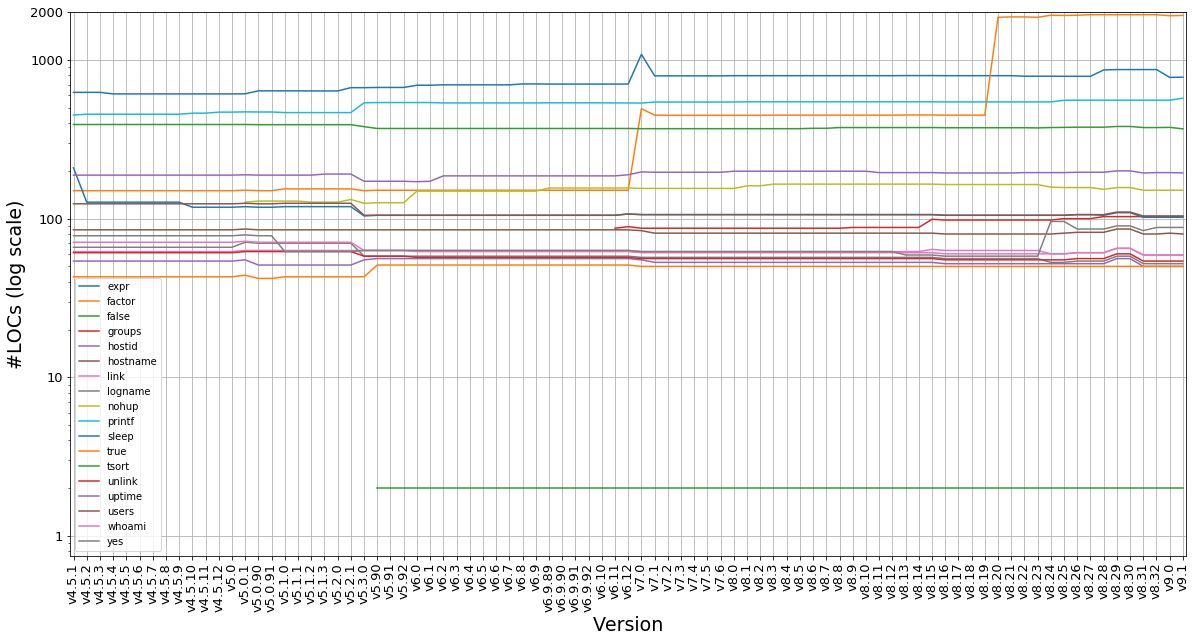

In [80]:
fig, ax = plt.subplots(1,figsize=(20,10))

for col in df.columns[1:]:
    tab = [int(k) for k in df[col] if k!='-']
    version = [i for i in range(df.shape[0]) if df[col][i]!='-']
    if len(tab)>0:
        plt.plot(version, tab, zorder=3, label = col)

plt.grid()
plt.legend()
plt.xticks(size=13)

ax.set_xticks([k for k in range(df.shape[0])])
ax.set_xticklabels(df['version'], size =13, rotation = 90)

plt.yscale("log")

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticks([1, 10, 100, 1000, 2000])
ax.set_yticklabels([1, 10, 100, 1000, 2000], size =13, rotation = 0)


plt.ylabel("#LOCs (log scale)", fontsize = 19)
plt.xlabel("Version", fontsize = 19)

ax.set_ylim(ymin=0.75, ymax=2000)
ax.set_xlim(xmin=-0.25, xmax=df.shape[0]-0.75)
plt.savefig("../figures/evo_loc2.png", dpi =300)
plt.show()

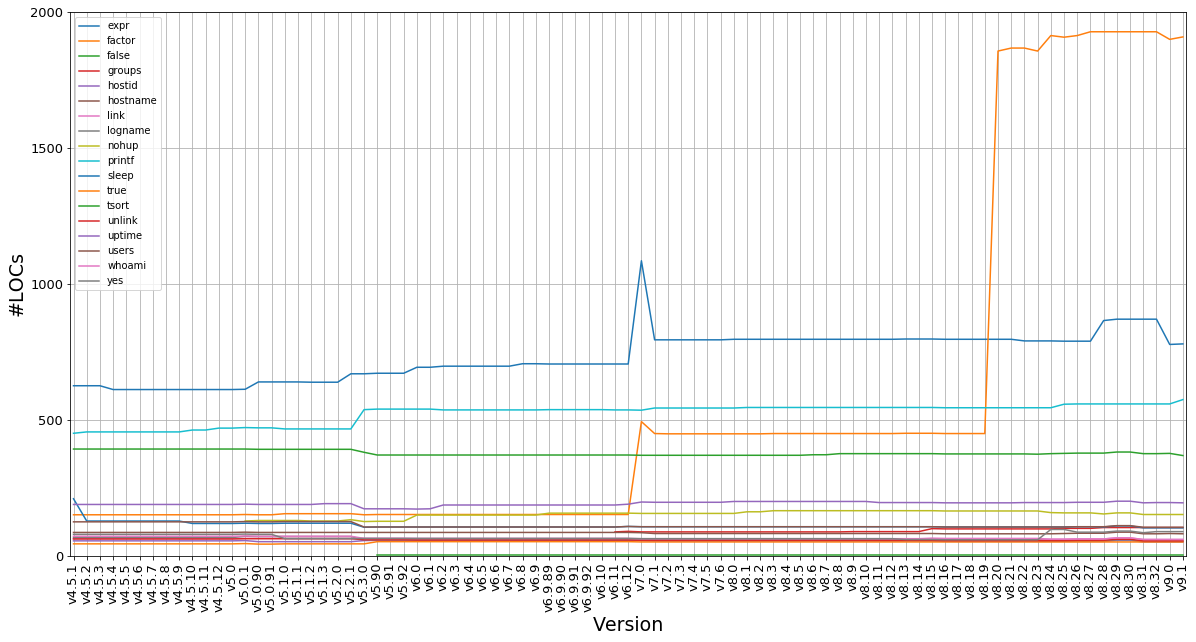

In [74]:
fig, ax = plt.subplots(1,figsize=(20,10))

for col in df.columns[1:]:
    tab = [int(k) for k in df[col] if k!='-']
    version = [i for i in range(df.shape[0]) if df[col][i]!='-']
    if len(tab)>0:
        plt.plot(version, tab, zorder=3, label = col)

plt.grid()
plt.legend()
plt.xticks(size=13)

ax.set_xticks([k for k in range(df.shape[0])])
ax.set_xticklabels(df['version'], size =13, rotation = 90)

#plt.yscale("log")

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticks([0, 500, 1000, 1500, 2000])
ax.set_yticklabels([0, 500, 1000, 1500, 2000], size =13, rotation = 0)


plt.ylabel("#LOCs", fontsize = 19)
plt.xlabel("Version", fontsize = 19)

ax.set_ylim(ymin=-1, ymax=2000)
ax.set_xlim(xmin=-0.25, xmax=df.shape[0]-0.75)
plt.savefig("../figures/evo_loc1.png", dpi =300)
plt.show()

In [30]:
df["false"][50]

'2'

### Correlations

#### Binary size x runtime 

In [12]:
#Pearson
np.corrcoef(binn, runt)[0,1]

0.5743654699232518

In [13]:
# Spearman
spearmanr(binn, runt)

SpearmanrResult(correlation=0.587240604503143, pvalue=6.12915234043042e-10)

#### LOC x runtime 

In [14]:
#Pearson
np.corrcoef(loc, runt)[0,1]

0.7410592255783667

In [15]:
# Spearman
spearmanr(loc, runt)

SpearmanrResult(correlation=0.6999582143556253, pvalue=5.863111208341474e-15)

#### Binary size x LOC

In [16]:
#Pearson
np.corrcoef(binn, loc)[0,1]

0.48487121131707656

In [17]:
# Spearman
spearmanr(binn, runt)

SpearmanrResult(correlation=0.587240604503143, pvalue=6.12915234043042e-10)

### Old figures

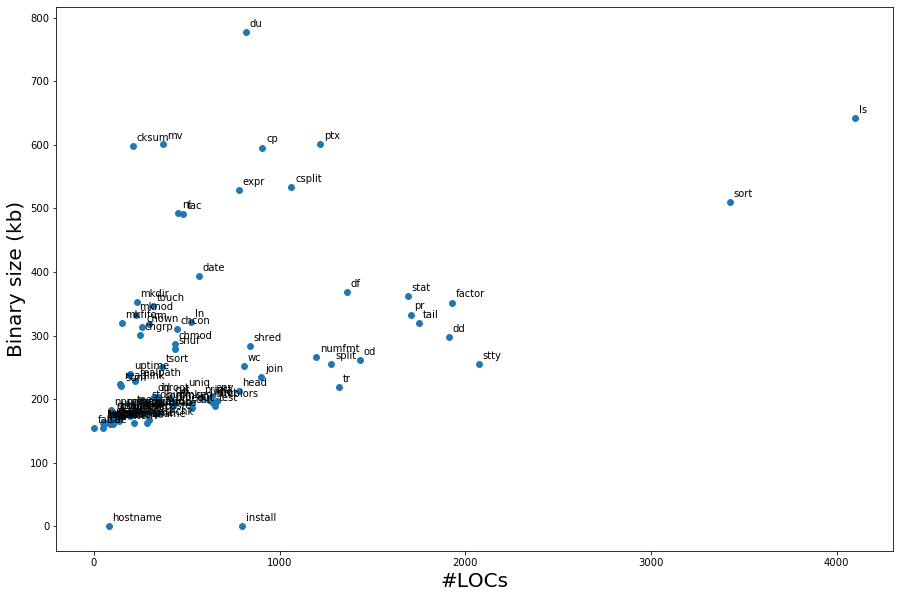

In [9]:
plt.figure(figsize=(15,10))

loc = df['loc']
binn = df['binary']
name = df['name']

plt.scatter(loc, binn, s= 35)

for i in range(len(binn)):
    plt.text(20+loc[i], 8+binn[i], name[i])

plt.ylabel("Binary size (kb)", fontsize =20)
plt.xlabel("#LOCs", fontsize = 20)
plt.savefig("../figures/kb_loc.png", dpi =300)
plt.show()

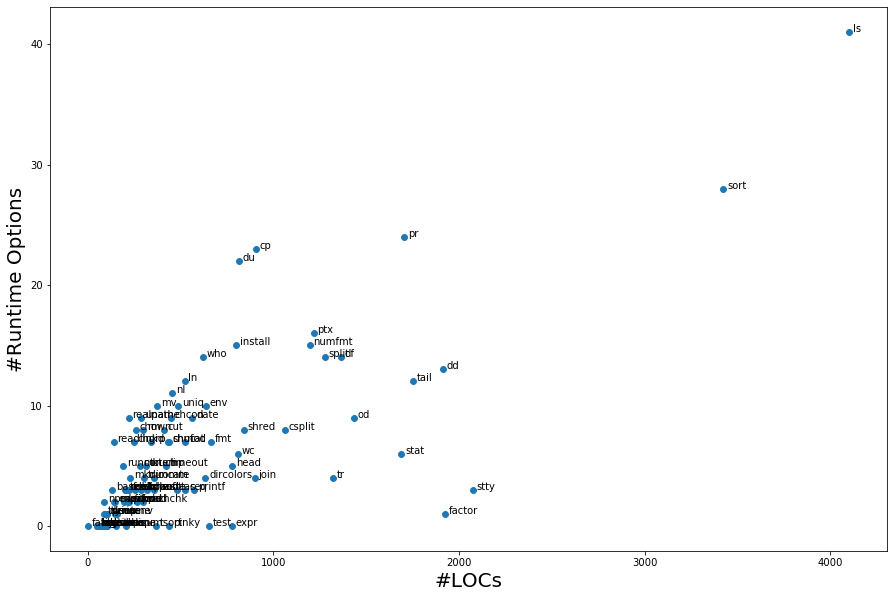

In [10]:
plt.figure(figsize=(15,10))

loc = df['loc']
runt = np.array(df['runtime'], dtype=float)
name = df['name']

plt.scatter(loc, runt, s= 35)

for i in range(len(loc)):
    plt.text(20+loc[i], runt[i], name[i])

plt.ylabel("#Runtime Options", fontsize =20)
plt.xlabel("#LOCs", fontsize = 20)
plt.savefig("../figures/run_loc.png", dpi =300)
plt.show()

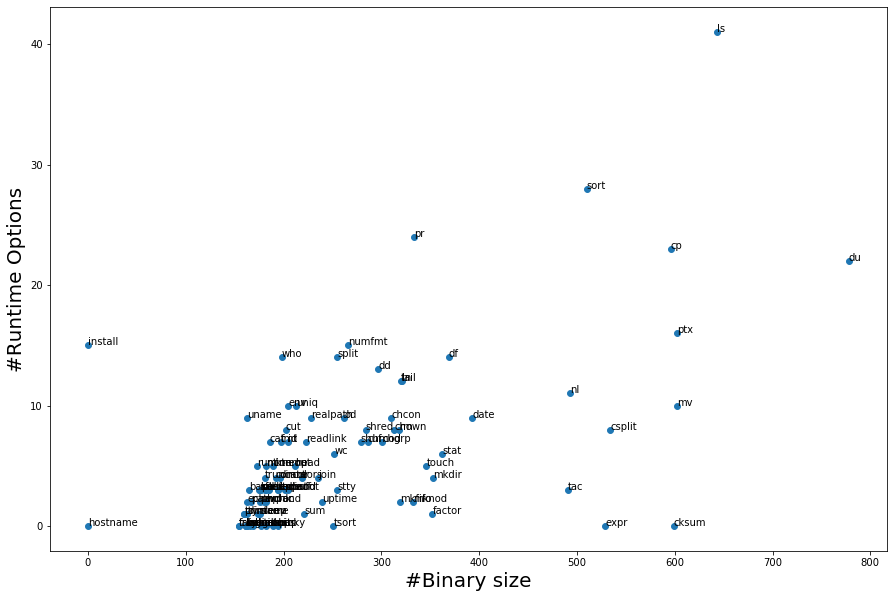

In [11]:
plt.figure(figsize=(15,10))

binn = df['binary']
runt = np.array(df['runtime'], dtype=float)
name = df['name']

plt.scatter(binn, runt, s= 35)

for i in range(len(loc)):
    plt.text(binn[i], runt[i], name[i])

plt.ylabel("#Runtime Options", fontsize =20)
plt.xlabel("#Binary size", fontsize = 20)
plt.savefig("../figures/run_kb.png", dpi =300)
plt.show()